# Determinaçao de Órbita a partir de TDM

## Análise Exploratória dos Dados

Inicialmente, devemos abrir o arquivo do TDM contendo os ângulos RAs e DECs a serem utilizados. 

In [2]:
from datetime import datetime
import pandas as pd

def get_track_data(filename):
    file = open(filename,'r')
    lines = file.readlines()

    tempo_utc_list = list()
    tempo_seconds_list = []
    ra = list()
    dec = list()

    break_lines = lines.count('\n')

    for i in range(break_lines):
        lines.remove('\n')

    for i, line in enumerate(lines):
        line = line.replace('\n','').replace('=','')
        lines[i] = line
        splitted_line = line.split(' ')
        tempo_utc = datetime.strptime(splitted_line[2],'%Y-%m-%dT%H:%M:%S.%f')
        tempo_seconds = tempo_utc.timestamp()
        if tempo_utc_list.count(tempo_utc) == 0:
            tempo_utc_list.append(tempo_utc)
            tempo_seconds_list.append(tempo_seconds)
        if splitted_line[0] == 'ANGLE_1':
            ra.append(float(splitted_line[3]))
        else:
            dec.append(float(splitted_line[3]))
    
    dados = {
        'Tempo (UTC)':tempo_utc_list,
        'Tempo[s]': tempo_seconds_list,
        'RA[deg]':ra,
        'DEC[deg]':dec
        }
    df = pd.DataFrame(data=dados)
    return df

Criando um dataframe para manipulação

In [3]:
tdm = get_track_data('Dados\\TDM_7646.txt')
r_11 = get_track_data('Dados\\Resultados-11.txt')
r_12 = get_track_data('Dados\\Resultados-12.txt')


In [4]:
tdm.tail()

,Tempo (UTC),Tempo[s],RA[deg],DEC[deg]
53,2023-04-25 09:54:06.305789,1.682427e+09,278.867539,-29.688960
54,2023-04-25 09:54:07.091175,1.682427e+09,279.119604,-29.512099
55,2023-04-25 09:54:07.873966,1.682427e+09,279.414237,-29.304023
56,2023-04-25 09:54:08.656703,1.682427e+09,279.708665,-29.094261
57,2023-04-25 09:54:09.439753,1.682427e+09,279.996322,-28.888321


Uma vez com os dataframes criados, temos que fazer um primeiro tratamento de dados para remoção de $\textit{outliers}$.

In [5]:
import numpy as np

# Informações para o RA do caso de 1.2 F.O.V.
mean = np.mean(r_12['RA[deg]'])
median = np.median(r_12['RA[deg]'])
std = np.std(r_12['RA[deg]'])

print(f'Resultados: \n Média = {mean} \n Mediana = {median} \n Desvio Padrão = {std}')

Resultados: 
 Média = 223.161198824588 
 Mediana = 219.7921202958874 
 Desvio Padrão = 17.068007935897214


Com os dados, podemos gerar os gráficos dos RAs e DECs em função do tempo:

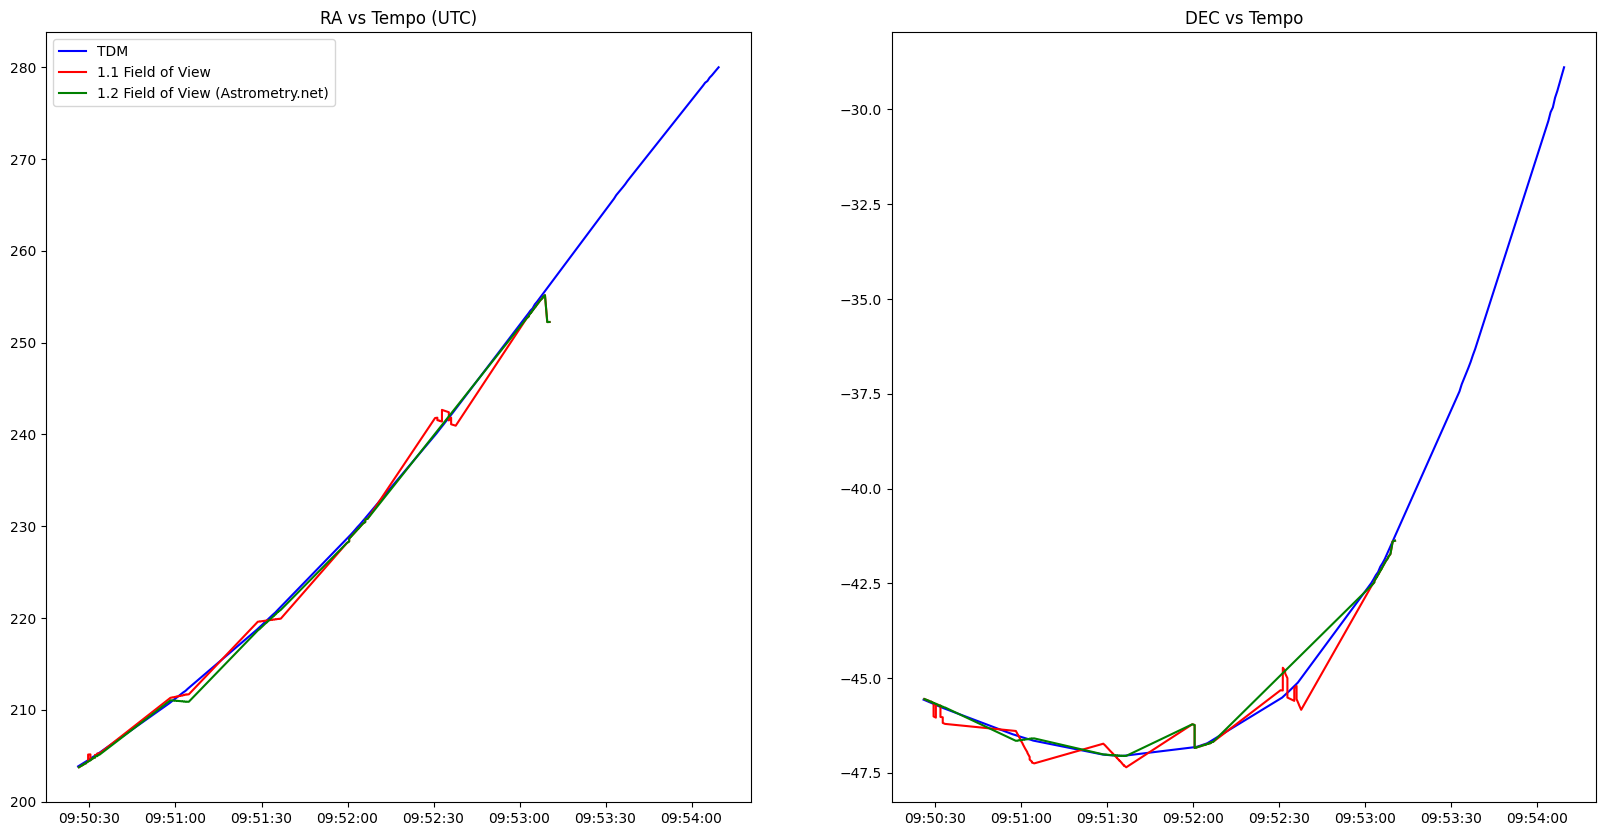

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(tdm['Tempo (UTC)'],tdm['RA[deg]'],color='blue')
plt.plot(r_11['Tempo (UTC)'],r_11['RA[deg]'],color='red')
plt.plot(r_12['Tempo (UTC)'],r_12['RA[deg]'],color='green')
plt.legend(['TDM','1.1 Field of View', '1.2 Field of View (Astrometry.net)'])
plt.title('RA vs Tempo (UTC)')

plt.subplot(1,2,2)
plt.plot(tdm['Tempo (UTC)'],tdm['DEC[deg]'],color='blue')
plt.plot(r_11['Tempo (UTC)'],r_11['DEC[deg]'],color='red')
plt.plot(r_12['Tempo (UTC)'],r_12['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

Dos gráficos apresentados, pode-se notar que, aparentemente, os dados calculados oscilam entorno dos dados do TDM fornecido pela Share My Space.

Assim, considera-se uma interpolação dos dados calculados.

In [7]:
def interpolar_dados(dados_originais : pd.DataFrame, dados_referencia : pd.DataFrame) -> pd.DataFrame:
    # Interpolação dos dados de 1.2 FOV:
    p_ra_fit = np.polynomial.polynomial.Polynomial.fit(dados_originais['Tempo[s]'],dados_originais['RA[deg]'],3)
    p_dec_fit = np.polynomial.polynomial.Polynomial.fit(dados_originais['Tempo[s]'],dados_originais['DEC[deg]'],3)

    ra_fit = []
    dec_fit = []
    desvio_ra = []
    desvio_dec = []
    for index, row in dados_referencia.iterrows():
        if row['Tempo[s]'] <= dados_originais['Tempo[s]'].max() :
            aux_ra = p_ra_fit(row['Tempo[s]'])
            aux_dec = p_dec_fit(row['Tempo[s]'])
            ra_fit.append(aux_ra)
            dec_fit.append(aux_dec)
            desvio_ra.append(100*np.abs((row['RA[deg]']-aux_ra)/row['RA[deg]']))
            desvio_dec.append(100*np.abs((row['DEC[deg]']-aux_dec)/row['DEC[deg]']))

        # aux_ra = p_ra_fit(row['Tempo[s]'])
        # aux_dec = p_dec_fit(row['Tempo[s]'])
        # ra_fit.append(aux_ra)
        # dec_fit.append(aux_dec)
        # desvio_ra.append(100*np.abs((row['RA[deg]']-aux_ra)/row['RA[deg]']))
        # desvio_dec.append(100*np.abs((row['DEC[deg]']-aux_dec)/row['DEC[deg]']))

    dados_fit = {
        'Tempo (UTC)': dados_referencia[dados_referencia['Tempo[s]'] <= dados_originais['Tempo[s]'].max()]['Tempo (UTC)'],
        'Tempo[s]': dados_referencia[dados_referencia['Tempo[s]'] <= dados_originais['Tempo[s]'].max()]['Tempo[s]'],
        # 'Tempo (UTC)': dados_referencia['Tempo (UTC)'],
        # 'Tempo[s]': dados_referencia['Tempo[s]'],
        'RA[deg]':ra_fit,
        'DEC[deg]':dec_fit,
        'Desvio RA (%)': desvio_ra,
        'Desvio DEC (%)': desvio_dec
    }

    dados_originais_fit = pd.DataFrame(data = dados_fit)
    return dados_originais_fit

In [8]:
# Interpolação dos dados de 1.2 FOV:
r_12_fit = interpolar_dados(r_12,tdm)

# Interpolação dos dados de 1.1 FOV:
r_11_fit = interpolar_dados(r_11,tdm)

In [9]:
#Clipagem dos dados do tdm
# tdm = tdm[tdm['Tempo[s]'] <= (r_12_fit['Tempo[s]']).max()]

Com a interpolção polinomial podemos novamente traçar as curvas dos valores obtidos:

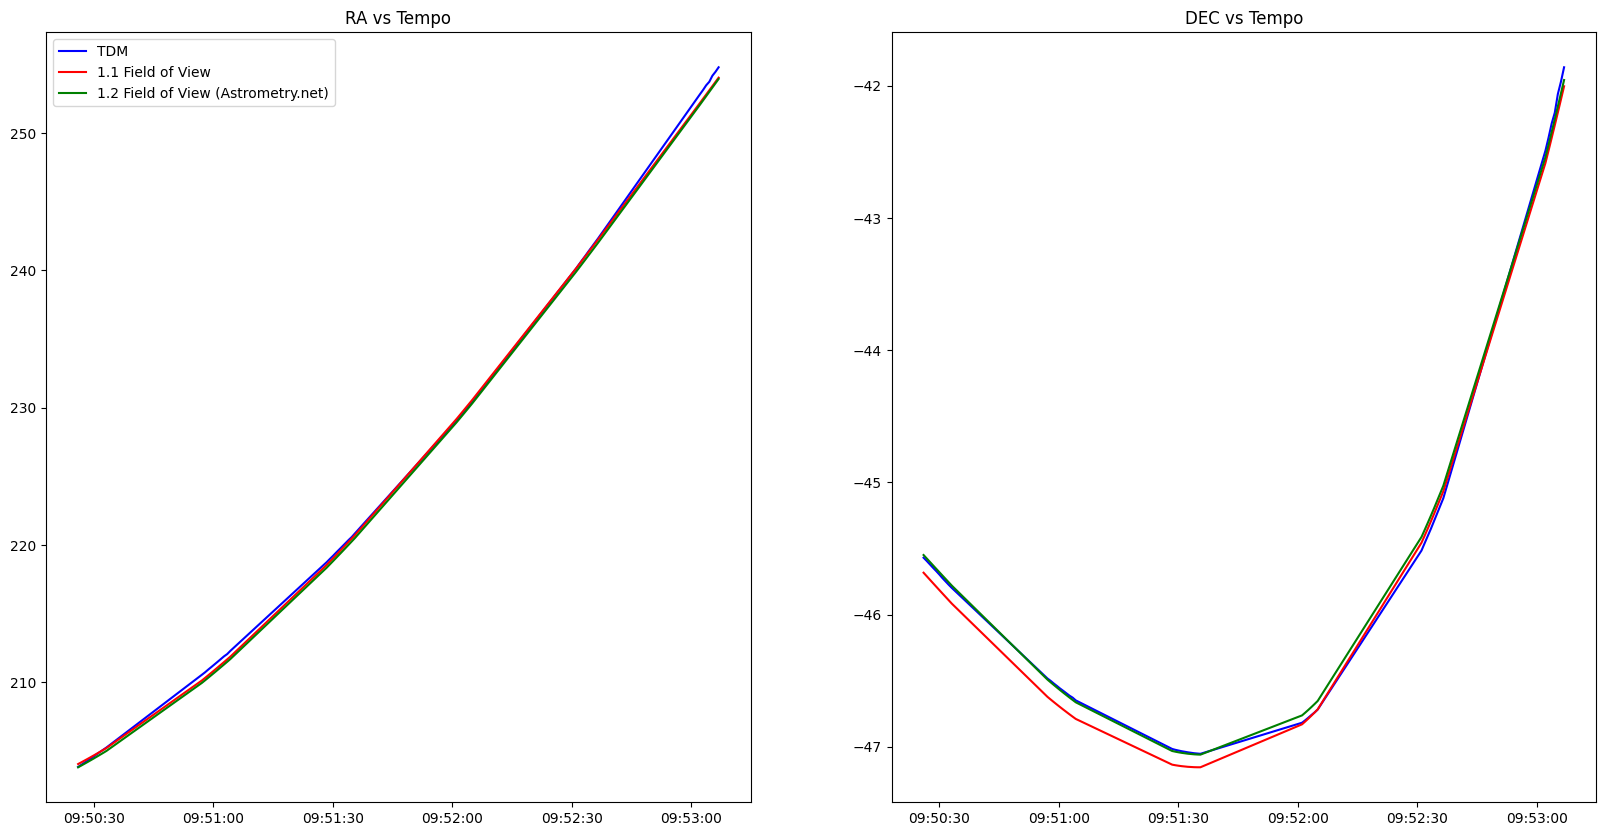

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
t_12_max = (r_12_fit['Tempo[s]']).max()
filter = (tdm['Tempo[s]'] <= t_12_max)
plt.plot(tdm[filter]['Tempo (UTC)'],tdm[filter]['RA[deg]'],color='blue')
plt.plot(r_11_fit['Tempo (UTC)'],r_11_fit['RA[deg]'],color='red')
plt.plot(r_12_fit['Tempo (UTC)'],r_12_fit['RA[deg]'],color='green')
plt.legend(['TDM','1.1 Field of View', '1.2 Field of View (Astrometry.net)'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(tdm[filter]['Tempo (UTC)'],tdm[filter]['DEC[deg]'],color='blue')
plt.plot(r_11_fit['Tempo (UTC)'],r_11_fit['DEC[deg]'],color='red')
plt.plot(r_12_fit['Tempo (UTC)'],r_12_fit['DEC[deg]'],color='green')
plt.title('DEC vs Tempo')
plt.show()

Ainda, uma vez obtido o polinômio de interpolação é possível obter o desvio relativo para cada posição em relação ao TDM fornecido pela Share My Space, assim:

In [11]:
import numpy as np

#Desvios para RA
median_ra = np.median(r_12_fit['Desvio RA (%)'])
mean_ra = np.mean(r_12_fit['Desvio RA (%)'])
std_ra = np.std(r_12_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(r_12_fit['Desvio DEC (%)'])
mean_dec = np.mean(r_12_fit['Desvio DEC (%)'])
std_dec = np.std(r_12_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': r_12_fit['Desvio RA (%)'].max(),
    'Máximo erro DEC (%)': r_12_fit['Desvio DEC (%)'].max()
}

stats = pd.DataFrame(index = ['1.2 FOV'] ,data = dados_stats)

#Desvios para RA
median_ra = np.median(r_11_fit['Desvio RA (%)'])
mean_ra = np.mean(r_11_fit['Desvio RA (%)'])
std_ra = np.std(r_11_fit['Desvio RA (%)'])

#Desvios para DEC
median_dec = np.median(r_11_fit['Desvio DEC (%)'])
mean_dec = np.mean(r_11_fit['Desvio DEC (%)'])
std_dec = np.std(r_11_fit['Desvio DEC (%)'])

dados_stats = {
    'Média RA (%)':mean_ra,
    'Média DEC (%)':mean_dec,
    'Mediana RA (%)':median_ra,
    'Mediana DEC (%)':median_dec,
    'Desvio Padrão RA (%)': std_ra,
    'Desvio Padrão DEC (%)': std_dec,
    'Máximo erro RA (%)': r_11_fit['Desvio RA (%)'].max(),
    'Máximo erro DEC (%)': r_11_fit['Desvio DEC (%)'].max()
}

stats = stats._append(dados_stats,ignore_index=True)
stats.index = ['1.2 FOV', '1.1 FOV']

stats.head()

,Média RA (%),Média DEC (%),Mediana RA (%),Mediana DEC (%),Desvio Padrão RA (%),Desvio Padrão DEC (%),Máximo erro RA (%),Máximo erro DEC (%)
1.2 FOV,0.173300,0.090934,0.155461,0.041014,0.100612,0.07625,0.338531,0.230141
1.1 FOV,0.114147,0.213354,0.077013,0.248713,0.092600,0.09859,0.296981,0.343098


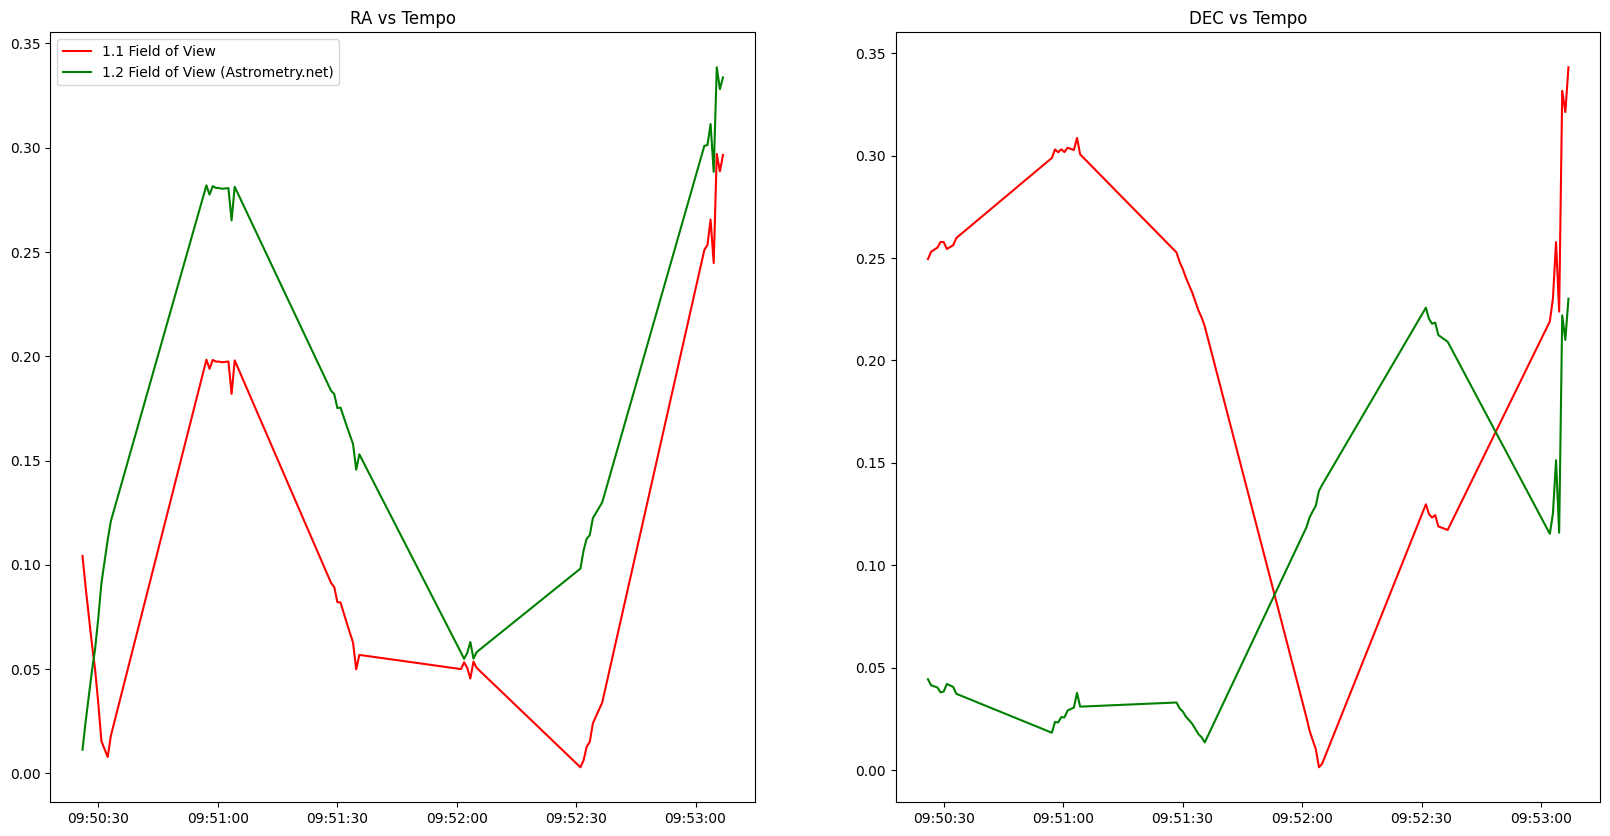

In [12]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(r_11_fit['Tempo (UTC)'],r_11_fit['Desvio RA (%)'],color='red')
plt.plot(r_12_fit['Tempo (UTC)'],r_12_fit['Desvio RA (%)'],color='green')
plt.legend(['1.1 Field of View', '1.2 Field of View (Astrometry.net)'])
plt.title('RA vs Tempo')

plt.subplot(1,2,2)
plt.plot(r_11_fit['Tempo (UTC)'],r_11_fit['Desvio DEC (%)'],color='red')
plt.plot(r_12_fit['Tempo (UTC)'],r_12_fit['Desvio DEC (%)'],color='green')
plt.title('DEC vs Tempo')
plt.show()

## Determinação da Órbita

Uma vez analisado os dados, tanto do TDM quanto os obtidos pelo $\textit{plate solving}$, podemos utilizar o método de Gauss ($\textit{angles only}$) para ter uma estimativa preliminar da órbita do objeto rastreado.

In [34]:
from datetime import datetime

def radec_fit(original_data:pd.DataFrame, poly_degree:int, t_start:float, t_end:float) -> pd.DataFrame:
    # Interpolação dos dados de 1.2 FOV:
    p_ra_fit = np.polynomial.polynomial.Polynomial.fit(original_data['Tempo[s]'],original_data['RA[deg]'],poly_degree)
    p_dec_fit = np.polynomial.polynomial.Polynomial.fit(original_data['Tempo[s]'],original_data['DEC[deg]'],poly_degree)

    ra_fit = []
    dec_fit = []
    t_utc = []
    t_seconds = np.linspace(t_start,t_end,100)

    for t in t_seconds:
        aux_ra = p_ra_fit(t)
        aux_dec = p_dec_fit(t)
        aux_t = datetime.fromtimestamp(t)
        t_utc.append(aux_t)
        ra_fit.append(aux_ra)
        dec_fit.append(aux_dec)

    dados_fit = {
        'Tempo (UTC)': t_utc,
        'Tempo[s]': t_seconds,
        'RA[deg]':ra_fit,
        'DEC[deg]':dec_fit,
    }

    return pd.DataFrame(data = dados_fit)

In [14]:
from src.orbit.orbit_determination import *

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_aldoria = get_track_data('Dados\\TDM_7646.txt')
tdm_saipher_bruto = get_track_data('Dados\\Resultados-12.txt')
tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max())
n_aldoria = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas
n_saipher = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas

# Posições Analisadas:
initial_aldoria = 0
middle_aldoria = int(n_aldoria/2)
end_aldoria = n_aldoria - 1
initial_saipher = 0
middle_saipher = int(n_saipher/2)
end_saipher = n_saipher - 1

# Parâmetros únicos de cada "TDM":
t_aldoria = [tdm_aldoria['Tempo[s]'][initial_aldoria],tdm_aldoria['Tempo[s]'][middle_aldoria],tdm_aldoria['Tempo[s]'][end_aldoria]] # Horário das observações utilizadas na IOD [s]
t_saipher = [tdm_saipher['Tempo[s]'][initial_saipher],tdm_saipher['Tempo[s]'][middle_saipher],tdm_saipher['Tempo[s]'][end_saipher]] # Horário das observações utilizadas na IOD [s]
local_sidereal_time_aldoria = [
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][initial_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][middle_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][end_aldoria]),
    ]
local_sidereal_time_saipher = [
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][initial_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][middle_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][end_saipher]),
    ]
RAs_aldoria = [tdm_aldoria['RA[deg]'][initial_aldoria],tdm_aldoria['RA[deg]'][middle_aldoria],tdm_aldoria['RA[deg]'][end_aldoria]]
DECs_aldoria = [tdm_aldoria['DEC[deg]'][initial_aldoria],tdm_aldoria['DEC[deg]'][middle_aldoria],tdm_aldoria['DEC[deg]'][end_aldoria]]
RAs_saipher = [tdm_saipher['RA[deg]'][initial_saipher],tdm_saipher['RA[deg]'][middle_saipher],tdm_saipher['RA[deg]'][end_saipher]]
DECs_saipher = [tdm_saipher['DEC[deg]'][initial_saipher],tdm_saipher['DEC[deg]'][middle_saipher],tdm_saipher['DEC[deg]'][end_saipher]]

# Estimativa inicial do vetor de estado do objeto (r2,v2):
r2_aldoria,v2_aldoria = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_aldoria,
    RAs = RAs_aldoria,
    DECs = DECs_aldoria,
    times = t_aldoria)

r2_saipher,v2_saipher = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_saipher,
    RAs = RAs_saipher,
    DECs = DECs_saipher,
    times = t_saipher)

# Obtenção dos elementos orbitais:
h_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria,theta_aldoria = classic_orbital_elements_from_rv(r2_aldoria,v2_aldoria)
h_saipher,i_saipher,ra_saipher,e_saipher,w_saipher,theta_saipher = classic_orbital_elements_from_rv(r2_saipher,v2_saipher)

# Obtenção do semi-eixo maior:
a_aldoria = semimajor_axis_from_he(h_aldoria,e_aldoria)
a_saipher = semimajor_axis_from_he(h_saipher,e_saipher)

# Dados do TLE
# 1 07646U 75010A   23115.56559076 -.00000125  00000-0  12485-4 0  9994
# 2 07646  49.8253 318.3095 0205748 228.5962 129.7086 13.82317979435651
e_tle = 0.02057480
i_tle = 49.8253
ra_tle = 318.3095
w_tle = 228.5962
a_tle = 7333.814
m_tle = 129.7086


# Resultados:
print('Parâmetros de Entrada:')
print('--------------------------------- Aldoria ----------------------------------')
print(f'RA = {np.round(RAs_aldoria,3)}')
print(f'DEC = {np.round(DECs_aldoria,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_aldoria,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_aldoria[0]-t_aldoria[0],t_aldoria[1]-t_aldoria[0],t_aldoria[2]-t_aldoria[0]],2)}')
print()
print('--------------------------------- Saipher ----------------------------------')
print(f'RA = {np.round(RAs_saipher,3)}')
print(f'DEC = {np.round(DECs_saipher,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_saipher,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_saipher[0]-t_saipher[0],t_saipher[1]-t_saipher[0],t_saipher[2]-t_saipher[0]],2)}')
print()

results = {
    'Aldoria':[a_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria],
    'Saipher':[a_saipher,i_saipher,ra_saipher,e_saipher,w_saipher],
    'TLE':[a_tle,i_tle,ra_tle,e_tle,w_tle]
}

orbital_parameters_df = pd.DataFrame(
    index = ['Semi-eixo maior [km]','Inclinação [°]','Ascensão reta do nó de ascensão [°]','Ecentricidade [-]','Argumento do Pergieu [°]'],
    data = results)

print('Vetores de Estado:')
print(f'v2_aldoria = {round(v2_aldoria.x,4)}I + ({round(v2_aldoria.y,4)})J + ({round(v2_aldoria.z,4)})K')
print(f'v2_saipher = {round(v2_saipher.x,4)}I + ({round(v2_saipher.y,4)})J + ({round(v2_saipher.z,4)})K')
print(f'r2_aldoria = {round(r2_aldoria.x,4)}I + ({round(r2_aldoria.y,4)})J + ({round(r2_aldoria.z,4)})K')
print(f'r2_saipher = {round(r2_saipher.x,4)}I + ({round(r2_saipher.y,4)})J + ({round(r2_saipher.z,4)})K')
print('\nParâmetros Orbitais:')
orbital_parameters_df

Parâmetros de Entrada:
--------------------------------- Aldoria ----------------------------------
RA = [203.848 230.168 279.996]
DEC = [-45.569 -46.74  -28.888]
Tempo Sideral = [289.914 290.324 290.846]
Intervalos de Tempo [s] = [  0.   98.2 223.4]

--------------------------------- Saipher ----------------------------------
RA = [203.87  224.659 255.376]
DEC = [-45.558 -46.993 -41.482]
Tempo Sideral = [289.914 290.257 290.6  ]
Intervalos de Tempo [s] = [  0.    82.16 164.15]

Vetores de Estado:
v2_aldoria = 6.2854I + (-1.3977)J + (3.6609)K
v2_saipher = 4.9989I + (-1.05)J + (2.8764)K
r2_aldoria = 1334.598I + (-5861.4097)J + (-4166.6119)K
r2_saipher = 1377.9596I + (-5692.78)J + (-4004.2499)K

Parâmetros Orbitais:


,Aldoria,Saipher,TLE
Semi-eixo maior [km],7363.593056,5110.647789,7333.814000
Inclinação [°],49.774642,49.477340,49.825300
Ascensão reta do nó de ascensão [°],318.718731,319.364653,318.309500
Ecentricidade [-],0.025400,0.389446,0.020575
Argumento do Pergieu [°],235.640729,134.976295,228.596200


Em uma análise preliminar, infere-se que a discrepância pode ocorrer devido a 2 fatores:
* Diferenças nos dados de RA e DEC
* Intervalo de tempo entre a primeira e a última observação

Para avaliar o efeito das diferenças nos dados de RA e DEC, podemos filtrar os dados do TDM da Aldoria para os quais o tempo é maior do que o tempo máximo obtido no TDM da Saipher, e, calcular a interpolação dos dados da Saipher para os dados presentes no TDM resultande:

In [15]:
from src.orbit.orbit_determination import *

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_aldoria_bruto = get_track_data('Dados\\TDM_7646.txt')
tdm_saipher_bruto = get_track_data('Dados\\Resultados-12.txt')

# Ajuste dos dados
# tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max())
tdm_aldoria = tdm_aldoria_bruto[tdm_aldoria_bruto['Tempo[s]'] <= max(tdm_saipher_bruto['Tempo[s]'])]
tdm_saipher = interpolar_dados(tdm_saipher_bruto,tdm_aldoria)

n_aldoria = len(tdm_aldoria['Tempo[s]'])                                # Quantidade de observações realizadas
n_saipher = len(tdm_saipher['Tempo[s]'])                                # Quantidade de observações realizadas

# Posições Analisadas:
initial_aldoria = 0
middle_aldoria = int(n_aldoria/2)
end_aldoria = n_aldoria - 1
initial_saipher = 0
middle_saipher = int(n_saipher/2)
end_saipher = n_saipher - 1

# Parâmetros únicos de cada "TDM":
t_aldoria = [tdm_aldoria['Tempo[s]'][initial_aldoria],tdm_aldoria['Tempo[s]'][middle_aldoria],tdm_aldoria['Tempo[s]'][end_aldoria]] # Horário das observações utilizadas na IOD [s]
t_saipher = [tdm_saipher['Tempo[s]'][initial_saipher],tdm_saipher['Tempo[s]'][middle_saipher],tdm_saipher['Tempo[s]'][end_saipher]] # Horário das observações utilizadas na IOD [s]
local_sidereal_time_aldoria = [
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][initial_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][middle_aldoria]),
    sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][end_aldoria]),
    ]
local_sidereal_time_saipher = [
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][initial_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][middle_saipher]),
    sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][end_saipher]),
    ]
RAs_aldoria = [tdm_aldoria['RA[deg]'][initial_aldoria],tdm_aldoria['RA[deg]'][middle_aldoria],tdm_aldoria['RA[deg]'][end_aldoria]]
DECs_aldoria = [tdm_aldoria['DEC[deg]'][initial_aldoria],tdm_aldoria['DEC[deg]'][middle_aldoria],tdm_aldoria['DEC[deg]'][end_aldoria]]
RAs_saipher = [tdm_saipher['RA[deg]'][initial_saipher],tdm_saipher['RA[deg]'][middle_saipher],tdm_saipher['RA[deg]'][end_saipher]]
# RAs_saipher = [
#     0.5*(tdm_saipher['RA[deg]'][initial_saipher] + RAs_aldoria[0]),
#     0.5*(tdm_saipher['RA[deg]'][middle_saipher] + RAs_aldoria[1]),
#     (1/4)*(tdm_saipher['RA[deg]'][end_saipher] + 3*RAs_aldoria[2])
# ]
DECs_saipher = [tdm_saipher['DEC[deg]'][initial_saipher],tdm_saipher['DEC[deg]'][middle_saipher],tdm_saipher['DEC[deg]'][end_saipher]]

# Estimativa inicial do vetor de estado do objeto (r2,v2):
r2_aldoria,v2_aldoria = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_aldoria,
    RAs = RAs_aldoria,
    DECs = DECs_aldoria,
    times = t_aldoria)

r2_saipher,v2_saipher = r2v2_from_angles_only_gauss(
    latitude_geodetic = latitude_geodetic,
    altitude = altitude,
    local_sidereal_times = local_sidereal_time_saipher,
    RAs = RAs_saipher,
    DECs = DECs_saipher,
    times = t_saipher)

# Obtenção dos elementos orbitais:
h_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria,theta_aldoria = classic_orbital_elements_from_rv(r2_aldoria,v2_aldoria)
h_saipher,i_saipher,ra_saipher,e_saipher,w_saipher,theta_saipher = classic_orbital_elements_from_rv(r2_saipher,v2_saipher)

# Obtenção do semi-eixo maior:
a_aldoria = semimajor_axis_from_he(h_aldoria,e_aldoria)
a_saipher = semimajor_axis_from_he(h_saipher,e_saipher)

# Dados do TLE
# 1 07646U 75010A   23115.56559076 -.00000125  00000-0  12485-4 0  9994
# 2 07646  49.8253 318.3095 0205748 228.5962 129.7086 13.82317979435651
e_tle = 0.02057480
i_tle = 49.8253
ra_tle = 318.3095
w_tle = 228.5962
a_tle = 7333.814
m_tle = 129.7086


# Resultados:
print('Parâmetros de Entrada:')
print('--------------------------------- Aldoria ----------------------------------')
print(f'RA = {np.round(RAs_aldoria,3)}')
print(f'DEC = {np.round(DECs_aldoria,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_aldoria,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_aldoria[0]-t_aldoria[0],t_aldoria[1]-t_aldoria[0],t_aldoria[2]-t_aldoria[0]],2)}')
print()
print('--------------------------------- Saipher ----------------------------------')
print(f'RA = {np.round(RAs_saipher,3)}')
print(f'DEC = {np.round(DECs_saipher,3)}')
print(f'Tempo Sideral = {np.round(local_sidereal_time_saipher,3)}')
print(f'Intervalos de Tempo [s] = {np.round([t_saipher[0]-t_saipher[0],t_saipher[1]-t_saipher[0],t_saipher[2]-t_saipher[0]],2)}')
print()

results = {
    'Aldoria':[a_aldoria,i_aldoria,ra_aldoria,e_aldoria,w_aldoria],
    'Saipher':[a_saipher,i_saipher,ra_saipher,e_saipher,w_saipher],
    'TLE':[a_tle,i_tle,ra_tle,e_tle,w_tle]
}

orbital_parameters_df = pd.DataFrame(
    index = ['Semi-eixo maior [km]','Inclinação [°]','Ascensão reta do nó de ascensão [°]','Ecentricidade [-]','Argumento do Pergieu [°]'],
    data = results)

print('Vetores de Estado:')
print(f'v2_aldoria = {round(v2_aldoria.x,4)}I + ({round(v2_aldoria.y,4)})J + ({round(v2_aldoria.z,4)})K')
print(f'v2_saipher = {round(v2_saipher.x,4)}I + ({round(v2_saipher.y,4)})J + ({round(v2_saipher.z,4)})K     (ex = {round(abs(100*(v2_saipher.x-v2_aldoria.x)/v2_aldoria.x),4)}% ey = {round(abs(100*(v2_saipher.y-v2_aldoria.y)/v2_aldoria.y),4)}% ez = {round(abs(100*(v2_saipher.z-v2_aldoria.z)/v2_aldoria.z),4)}%)')
print(f'r2_aldoria = {round(r2_aldoria.x,4)}I + ({round(r2_aldoria.y,4)})J + ({round(r2_aldoria.z,4)})K')
print(f'r2_saipher = {round(r2_saipher.x,4)}I + ({round(r2_saipher.y,4)})J + ({round(r2_saipher.z,4)})K     (ex = {round(abs(100*(r2_saipher.x-r2_aldoria.x)/r2_aldoria.x),4)}% ey = {round(abs(100*(r2_saipher.y-r2_aldoria.y)/r2_aldoria.y),4)}% ez = {round(abs(100*(r2_saipher.z-r2_aldoria.z)/r2_aldoria.z),4)}%)')
print('\nParâmetros Orbitais:')
orbital_parameters_df

Parâmetros de Entrada:
--------------------------------- Aldoria ----------------------------------
RA = [203.848 220.379 254.792]
DEC = [-45.569 -47.048 -41.86 ]
Tempo Sideral = [289.914 290.194 290.583]
Intervalos de Tempo [s] = [  0.    67.95 160.86]

--------------------------------- Saipher ----------------------------------
RA = [203.825 220.031 253.942]
DEC = [-45.549 -47.056 -41.956]
Tempo Sideral = [289.914 290.194 290.583]
Intervalos de Tempo [s] = [  0.    67.95 160.86]

Vetores de Estado:
v2_aldoria = 6.5923I + (-1.6768)J + (3.6772)K
v2_saipher = 4.4961I + (-0.8379)J + (2.6065)K     (ex = 31.7977% ey = 50.0307% ez = 29.1156%)
r2_aldoria = 1107.6411I + (-5846.9734)J + (-4325.9949)K
r2_saipher = 1383.7565I + (-5606.7598)J + (-3933.1134)K     (ex = 24.9282% ey = 4.1083% ez = 9.0819%)

Parâmetros Orbitais:


,Aldoria,Saipher,TLE
Semi-eixo maior [km],8207.623014,4614.259487,7333.814000
Inclinação [°],49.831410,49.159644,49.825300
Ascensão reta do nó de ascensão [°],318.579299,319.929321,318.309500
Ecentricidade [-],0.105714,0.514482,0.020575
Argumento do Pergieu [°],296.987176,132.903176,228.596200


Analisando a diferença percentual entre os dados de entrada da Aldoria e da Saipher, temos:

In [16]:
diff_ra = []
diff_dec = []
desvio_ra = []
desvio_dec = []
for i in range(0,3):
    diff_ra_aux = RAs_aldoria[i]-RAs_saipher[i]
    diff_dec_aux = DECs_aldoria[i]-DECs_saipher[i]
    diff_ra.append(diff_ra_aux)
    diff_dec.append(diff_dec_aux)
    desvio_ra.append(abs(100*(diff_ra_aux)/RAs_aldoria[i]))
    desvio_dec.append(abs(100*(diff_dec_aux)/DECs_aldoria[i]))

print(f'diff_RA =  {np.round(diff_ra,3)} [°]')
print(f'diff_DEC = {np.round(diff_dec,3)} [°]')
print(f'desvio_RA =  {np.round(desvio_ra,3)} [%]')
print(f'desvio_DEC = {np.round(desvio_dec,3)} [%]')

diff_RA =  [0.023 0.348 0.85 ] [°]
diff_DEC = [-0.02   0.008  0.096] [°]
desvio_RA =  [0.011 0.158 0.334] [%]
desvio_DEC = [0.044 0.018 0.23 ] [%]


Portanto, nota-se que uma pequena diferença nos dados de entrada de RA e DEC, pode alterar significativamente os parâmetros orbitais obtidos, principalmente para o semieixo maior, ecentricidade e o argumento do perigeu.
Ainda, nota-se que ao diminuir o intervalo entre a primeira e a última observação dos dados do TDM da Aldoria houve uma perda significativa de acurácia no método.

Na literatura, ressalta-se os seguintes pontos acerca do algoritmo de Gauss para determinação de órbita a partir de fotos de telescópio:
* O intervalo de tempo de observação ($\Delta t$) é importante. Se for muito pequeno, os erros são geralmente maiores.
* O algoritmo de Gauss funciona para $\Delta t$ pequeno, portanto é necessário fazer um $\textit{tradeoff}$.
* O erro na estimativa da ecentricidade é um problema bem conhecido para a determinação preliminar de órbita.
* Para órbitas LEO, sugere-se assumir $e = 0$ para determinação preliminar da órbita.
* Imprecisão nas coordenadas do satélite obtida na foto de telescópio impactando nos RAs e DECs observados.
* Diferenças de RA e DEC de até $0.25\degree$ geram desvios pequenos nos parâmetros orbitais calculados

Com isso, podemos avaliar os parâmetros orbitais obtidos considerando os diferentes intervalos de tempo nos dados observados. Para isso, mantendo-se fixo a observação de entrada, podemos aumentar gradativamente o tempo da observação final, conjuntamente com a observação central.

c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:50: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  x = fsolve(f,x0)
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:28: RuntimeWarning: overflow encountered in cosh
  return (np.cosh(np.sqrt(-z))-1)/(-z)
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:16: RuntimeWarning: overflow encountered in sinh
  return (np.sinh(z_sqrt)-z_sqrt)/(pow(z_sqrt,3))
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:50: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  x = fsolve(f,x0)
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:48: RuntimeWarning: invalid value encountered in add
  f = lambda x : (r*vr*pow(x,2)*stumpff_C(alpha*pow(x,2)))/mu_sqrt 

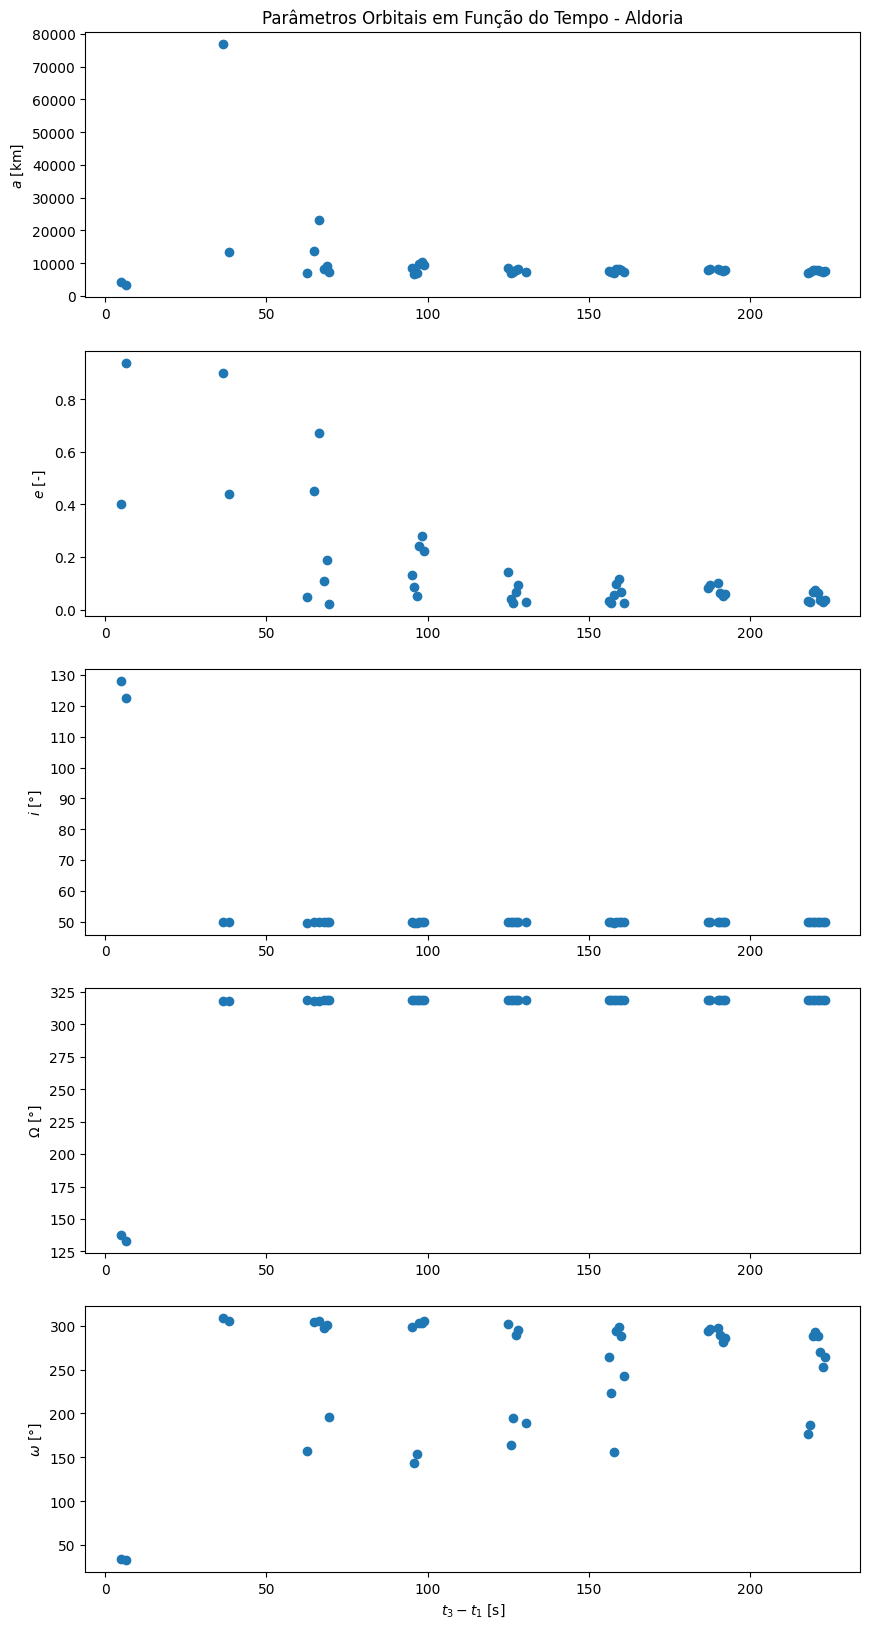

In [29]:
# Parâmetros Orbitais para a Aldoria

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_aldoria_bruto = get_track_data('Dados\\TDM_7646.txt')

# Ajuste dos dados
tdm_aldoria = tdm_aldoria_bruto

n_aldoria = len(tdm_aldoria['Tempo[s]'])  # Quantidade de observações realizadas

# Parâmetros:
dt_aldoria = []
a_aldoria = []
i_aldoria = []
omega_aldoria = []
w_aldoria = []
e_aldoria = []

for n in range(2,n_aldoria):
    # Posições Analisadas:
    initial_aldoria = 0
    middle_aldoria = int(n/2)
    end_aldoria = n

    # Parâmetros únicos de cada "TDM":
    t_aldoria = [tdm_aldoria['Tempo[s]'][initial_aldoria],tdm_aldoria['Tempo[s]'][middle_aldoria],tdm_aldoria['Tempo[s]'][end_aldoria]] # Horário das observações utilizadas na IOD [s]
    local_sidereal_time_aldoria = [
        sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][initial_aldoria]),
        sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][middle_aldoria]),
        sidereal_time(longitude=longitude,date=tdm_aldoria['Tempo (UTC)'][end_aldoria]),
        ]
    RAs_aldoria = [tdm_aldoria['RA[deg]'][initial_aldoria],tdm_aldoria['RA[deg]'][middle_aldoria],tdm_aldoria['RA[deg]'][end_aldoria]]
    DECs_aldoria = [tdm_aldoria['DEC[deg]'][initial_aldoria],tdm_aldoria['DEC[deg]'][middle_aldoria],tdm_aldoria['DEC[deg]'][end_aldoria]]

    # Estimativa inicial do vetor de estado do objeto (r2,v2):
    r2,v2 = r2v2_from_angles_only_gauss(
        latitude_geodetic = latitude_geodetic,
        altitude = altitude,
        local_sidereal_times = local_sidereal_time_aldoria,
        RAs = RAs_aldoria,
        DECs = DECs_aldoria,
        times = t_aldoria)
    
    # Parâmetros Orbitais:
    h,i,omega,e,w,theta = classic_orbital_elements_from_rv(r2,v2)
    a = semimajor_axis_from_he(h,e)

    # Adição dos Dados Obtidos:
    dt_aldoria.append(t_aldoria[2] - t_aldoria[0])
    a_aldoria.append(a)
    i_aldoria.append(i)
    omega_aldoria.append(omega)
    w_aldoria.append(w)
    e_aldoria.append(e)

# Criação de Data Frame com os Dados:
orbital_param_aldoria = pd.DataFrame(data={
    'Delta_t' : dt_aldoria,
    'a':a_aldoria,
    'i':i_aldoria,
    'omega':omega_aldoria,
    'w':w_aldoria,
    'e':e_aldoria,
})

# Filtro de Outliers:
orbital_param_aldoria.dropna(inplace=True)
orbital_param_aldoria.where((orbital_param_aldoria['e'] < 1),inplace=True)

# Plot dos Resultados:
plt.figure(figsize=(10,20))
# plt.rcParams['text.usetex'] = True
ax1 = plt.subplot(5,1,1)
ax1.scatter(orbital_param_aldoria['Delta_t'],orbital_param_aldoria['a'])
ax1.set_ylabel('$a$ [km]')
ax1.set_title('Parâmetros Orbitais em Função do Tempo - Aldoria')
ax2 = plt.subplot(5,1,2)
ax2.scatter(orbital_param_aldoria['Delta_t'],orbital_param_aldoria['e'])
ax2.set_ylabel('$e$ [-]')
ax3 = plt.subplot(5,1,3)
ax3.scatter(orbital_param_aldoria['Delta_t'],orbital_param_aldoria['i'])
ax3.set_ylabel('$i$ [°]')
ax4 = plt.subplot(5,1,4)
ax4.scatter(orbital_param_aldoria['Delta_t'],orbital_param_aldoria['omega'])
ax4.set_ylabel('$\\Omega$ [°]')
ax5 = plt.subplot(5,1,5)
ax5.scatter(orbital_param_aldoria['Delta_t'],orbital_param_aldoria['w'])
ax5.set_ylabel('$\\omega$ [°]')
ax5.set_xlabel('$t_3 - t_1$ [s]')
plt.show()

c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:50: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  x = fsolve(f,x0)
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:28: RuntimeWarning: overflow encountered in cosh
  return (np.cosh(np.sqrt(-z))-1)/(-z)
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:16: RuntimeWarning: overflow encountered in sinh
  return (np.sinh(z_sqrt)-z_sqrt)/(pow(z_sqrt,3))
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:48: RuntimeWarning: invalid value encountered in add
  f = lambda x : (r*vr*pow(x,2)*stumpff_C(alpha*pow(x,2)))/mu_sqrt + (1-alpha*r)*pow(x,3)*stumpff_S(alpha*pow(x,2)) + r*x - dt*mu_sqrt
c:\Users\rafael.facchin\Documents\Referências\Projeto Horus\spacepykit\src\orbit\orbit.py:50: RuntimeWarning: The iteration is not making good progress, as measured by 

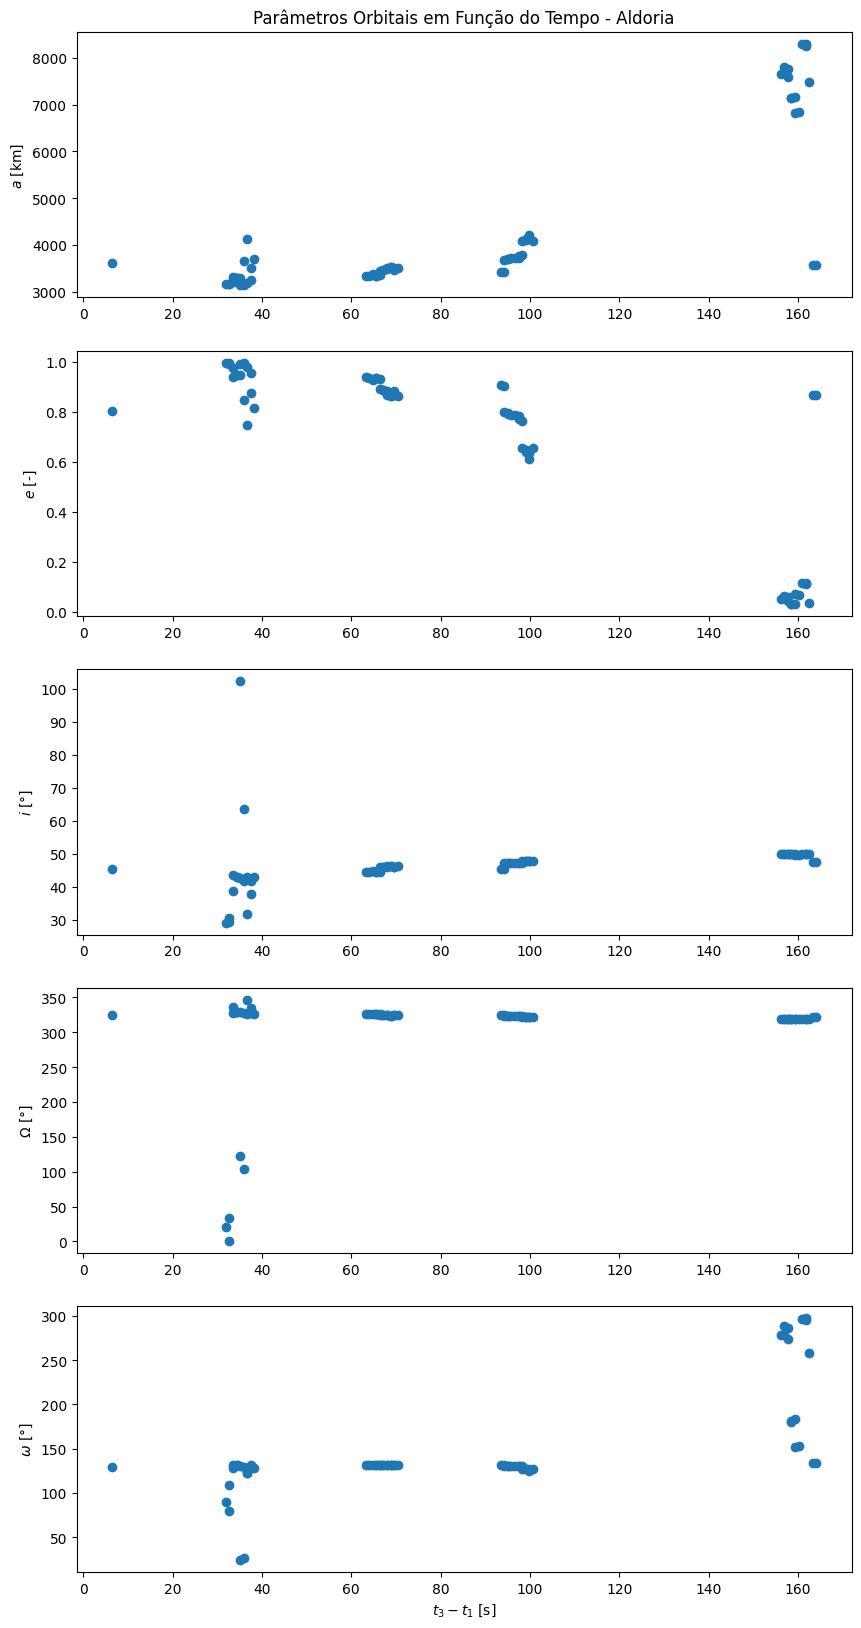

In [45]:
# Parâmetros Orbitais para a Saipher

# Dados do Observatório da Aldoria:
latitude = -30.5262693                                          # Latitude geocêntrica do observatório [deg]
longitude = -70.8531799                                         # [deg]
altitude = 2180e-3                                              # [km]
latitude_geodetic = np.rad2deg(get_geodetic_latitude(latitude)) # Latitude geodética do observatório [deg]

# Observações:
tdm_saipher_bruto = get_track_data('Dados\\Resultados-12.txt')

# Ajuste dos dados
# tdm_saipher = radec_fit(original_data=tdm_saipher_bruto,poly_degree=3,t_start=tdm_saipher_bruto['Tempo[s]'].min(),t_end=tdm_saipher_bruto['Tempo[s]'].max()+60)
tdm_saipher = tdm_saipher_bruto

n_saipher = len(tdm_saipher['Tempo[s]'])  # Quantidade de observações realizadas

# Parâmetros:
dt_saipher = []
a_saipher = []
i_saipher = []
omega_saipher = []
w_saipher = []
e_saipher = []

for n in range(2,n_saipher):
    # Posições Analisadas:
    initial_saipher = 0
    middle_saipher = int(n/2)
    end_saipher = n

    # Parâmetros únicos de cada "TDM":
    t_saipher = [tdm_saipher['Tempo[s]'][initial_saipher],tdm_saipher['Tempo[s]'][middle_saipher],tdm_saipher['Tempo[s]'][end_saipher]] # Horário das observações utilizadas na IOD [s]
    local_sidereal_time_saipher = [
        sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][initial_saipher]),
        sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][middle_saipher]),
        sidereal_time(longitude=longitude,date=tdm_saipher['Tempo (UTC)'][end_saipher]),
        ]
    RAs_saipher = [tdm_saipher['RA[deg]'][initial_saipher],tdm_saipher['RA[deg]'][middle_saipher],tdm_saipher['RA[deg]'][end_saipher]]
    DECs_saipher = [tdm_saipher['DEC[deg]'][initial_saipher],tdm_saipher['DEC[deg]'][middle_saipher],tdm_saipher['DEC[deg]'][end_saipher]]

    # Estimativa inicial do vetor de estado do objeto (r2,v2):
    r2,v2 = r2v2_from_angles_only_gauss(
        latitude_geodetic = latitude_geodetic,
        altitude = altitude,
        local_sidereal_times = local_sidereal_time_saipher,
        RAs = RAs_saipher,
        DECs = DECs_saipher,
        times = t_saipher)
    
    # Parâmetros Orbitais:
    h,i,omega,e,w,theta = classic_orbital_elements_from_rv(r2,v2)
    a = semimajor_axis_from_he(h,e)

    # Adição dos Dados Obtidos:
    dt_saipher.append(t_saipher[2] - t_saipher[0])
    a_saipher.append(a)
    i_saipher.append(i)
    omega_saipher.append(omega)
    w_saipher.append(w)
    e_saipher.append(e)

# Criação de Data Frame com os Dados:
orbital_param_saipher = pd.DataFrame(data={
    'Delta_t' : dt_saipher,
    'a':a_saipher,
    'i':i_saipher,
    'omega':omega_saipher,
    'w':w_saipher,
    'e':e_saipher,
})

# Filtro de Outliers:
orbital_param_saipher.dropna(inplace=True)
orbital_param_saipher.where((orbital_param_saipher['e'] < 1),inplace=True)

# Plot dos Resultados:
plt.figure(figsize=(10,20))
# plt.rcParams['text.usetex'] = True
ax1 = plt.subplot(5,1,1)
ax1.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['a'])
ax1.set_ylabel('$a$ [km]')
ax1.set_title('Parâmetros Orbitais em Função do Tempo - Aldoria')
ax2 = plt.subplot(5,1,2)
ax2.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['e'])
ax2.set_ylabel('$e$ [-]')
ax3 = plt.subplot(5,1,3)
ax3.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['i'])
ax3.set_ylabel('$i$ [°]')
ax4 = plt.subplot(5,1,4)
ax4.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['omega'])
ax4.set_ylabel('$\\Omega$ [°]')
ax5 = plt.subplot(5,1,5)
ax5.scatter(orbital_param_saipher['Delta_t'],orbital_param_saipher['w'])
ax5.set_ylabel('$\\omega$ [°]')
ax5.set_xlabel('$t_3 - t_1$ [s]')
plt.show()

In [47]:
orbital_param_saipher.describe()
df_saipher = orbital_param_saipher[orbital_param_saipher.e < orbital_param_saipher.describe().e['25%']]
df_saipher.describe()
# orbital_param_saipher[orbital_param_saipher.e == orbital_param_saipher.describe().e['min']]

,Delta_t,a,i,omega,w,e
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,151.760739,7148.755617,49.555186,319.084290,228.405490,0.133527
std,20.348189,1250.626105,0.647402,1.105590,67.262982,0.193784
min,99.855688,4138.463504,47.887381,318.562367,125.240502,0.031826
25%,156.946243,7073.121740,49.756767,318.644042,173.437506,0.041165
50%,158.546867,7541.562754,49.795852,318.673395,265.998130,0.062733
75%,160.347581,7775.770307,49.806507,318.767029,286.628410,0.112169
max,162.548483,8301.261064,49.839822,321.927030,297.168922,0.636689


In [50]:
orbital_param_aldoria.describe()
df_aldoria = orbital_param_aldoria[orbital_param_aldoria.e < orbital_param_aldoria.describe().e['25%']]
df_aldoria.describe()
# orbital_param_aldoria[orbital_param_aldoria.e == orbital_param_aldoria.describe().e['min']]

,Delta_t,a,i,omega,w,e
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,173.197022,7332.030486,49.771594,318.726250,223.663780,0.029423
std,51.808360,148.296881,0.012935,0.030521,36.384292,0.005097
min,69.527334,7129.629550,49.756267,318.681551,176.665413,0.021131
25%,143.359138,7208.559822,49.760324,318.699632,191.565975,0.026221
50%,160.862672,7320.545231,49.766030,318.736404,223.663281,0.029182
75%,220.267429,7467.643312,49.782611,318.753069,258.745083,0.034023
max,223.401300,7542.144117,49.790729,318.761742,270.374882,0.037537
